# A flood prediction model.

## Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Visuals
from matplotlib.ticker import PercentFormatter # Change yticks format
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import polars as pl

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import catboost as cb

from sklearn.pipeline import Pipeline # Pipeline method


from sklearn import set_config # To display the pipeline

from sklearn.linear_model import LinearRegression #Lin reg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # Train test split

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import f1_score

from sklearn import preprocessing # Preprocessing module
from sklearn.preprocessing import OneHotEncoder, StandardScaler , MinMaxScaler
from sklearn.impute import SimpleImputer


pd.set_option('display.float_format', lambda x: '%.2f' % x)
        
        
# Set the option to display all columns
pd.set_option('display.max_columns', None)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


## Importing the datasets

In [2]:
# Load the datasets
df_train = pd.read_csv("/kaggle/input/playground-series-s4e5/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e5/test.csv")
df_sample_sub = pd.read_csv("/kaggle/input/playground-series-s4e5/sample_submission.csv")




# Dropping ID columns
df_train.drop(columns=['id'], axis=1, inplace=True)
df_test.drop(columns=['id'], axis=1, inplace=True)



# Distribution of target variable

In [3]:
"""
# Initialize the figure
fig , ax = plt.subplots(figsize=(6,4))
plt.style.use("seaborn-whitegrid")

# Plots
n, bins , patches = plt.hist(df_train["FloodProbability"], bins=50 , facecolor="#2ab0ff", edgecolor="#169acf",linewidth=0.5)

# Attributes
plt.grid(False)
plt.title("Distribution of flood probability")
plt.xlabel("Probability")
plt.ylabel("Frequency")
patches[24].set_fc('red')
#plt.annotate('Bin n°24', xy=(0.5,40000), xytext=(0.6,41000), arrowprops=dict(facecolor='red',shrink=0.1))
ax.xaxis.set_major_formatter(PercentFormatter(1))


plt.show()
"""

'\n# Initialize the figure\nfig , ax = plt.subplots(figsize=(6,4))\nplt.style.use("seaborn-whitegrid")\n\n# Plots\nn, bins , patches = plt.hist(df_train["FloodProbability"], bins=50 , facecolor="#2ab0ff", edgecolor="#169acf",linewidth=0.5)\n\n# Attributes\nplt.grid(False)\nplt.title("Distribution of flood probability")\nplt.xlabel("Probability")\nplt.ylabel("Frequency")\npatches[24].set_fc(\'red\')\n#plt.annotate(\'Bin n°24\', xy=(0.5,40000), xytext=(0.6,41000), arrowprops=dict(facecolor=\'red\',shrink=0.1))\nax.xaxis.set_major_formatter(PercentFormatter(1))\n\n\nplt.show()\n'

# Distribution of dependent variables

In [4]:
"""

# Elimina la columna "FloodProbability" de df_train y agrega la columna "origin" con el valor "train"
t_df = df_train.copy()
t_df["origin"] = "train"

# Agrega la columna "origin" con el valor "test" a df_test
test_df=df_test.copy()

test_df["origin"] = "test"

# Concatena los DataFrames df_train y df_test en un solo DataFrame total_df
total_df = pd.concat([t_df, test_df])

# Crea los subgráficos
fig, axs = plt.subplots(5, 4, figsize=(18, 16))

# Itera sobre las filas y columnas de axs
for row in range(5):
    for col in range(4):
        i = row * 4 + col  # Calcula el índice correspondiente a la columna actual
        if i < len(total_df.columns) - 1:  # Verifica que el índice sea válido
            # Accede al eje correspondiente en la matriz de ejes axs
            ax = axs[row, col]

            # Utiliza sns.histplot especificando el eje en el que deseas que se dibuje el histograma
            sns.histplot(data=total_df, x=total_df.columns[i], hue="origin", binwidth=2, stat="density", multiple="dodge", ax=ax)

            # Ajusta el título para que se ajuste al eje
            ax.set_title(total_df.columns[i])
            ax.set_xlabel("")
            ax.grid(False)
            



# Ajusta el diseño de los subgráficos y muestra el gráfico
plt.tight_layout()
plt.show()


"""

'\n\n# Elimina la columna "FloodProbability" de df_train y agrega la columna "origin" con el valor "train"\nt_df = df_train.copy()\nt_df["origin"] = "train"\n\n# Agrega la columna "origin" con el valor "test" a df_test\ntest_df=df_test.copy()\n\ntest_df["origin"] = "test"\n\n# Concatena los DataFrames df_train y df_test en un solo DataFrame total_df\ntotal_df = pd.concat([t_df, test_df])\n\n# Crea los subgráficos\nfig, axs = plt.subplots(5, 4, figsize=(18, 16))\n\n# Itera sobre las filas y columnas de axs\nfor row in range(5):\n    for col in range(4):\n        i = row * 4 + col  # Calcula el índice correspondiente a la columna actual\n        if i < len(total_df.columns) - 1:  # Verifica que el índice sea válido\n            # Accede al eje correspondiente en la matriz de ejes axs\n            ax = axs[row, col]\n\n            # Utiliza sns.histplot especificando el eje en el que deseas que se dibuje el histograma\n            sns.histplot(data=total_df, x=total_df.columns[i], hue="or

## Linear relationship between target variable and independent variables

In [5]:
pol_col = ["RiverManagement","DamsQuality","IneffectiveDisasterPreparedness","DrainageSystems",
          "DeterioratingInfrastructure","InadequatePlanning","PoliticalFactors","Encroachments"]

nat_col = ["MonsoonIntensity","TopographyDrainage","Siltation","Landslides","Watersheds"]

hum_col = ["Deforestation","Urbanization","AgriculturalPractices","CoastalVulnerability","PopulationScore",
          "WetlandLoss",]

agr = [pol_col,nat_col,hum_col]
agrp = ["pol_col","nat_col","hum_col"]

In [6]:
def feature_eng(dataframe: pd.DataFrame, list_argument, list_name) -> pd.DataFrame:
    if isinstance(list_argument[0], list):  
        for i, sublist in enumerate(list_argument):
            mean_values = np.mean(dataframe[sublist], axis=1)
            log_mean_values = np.where(mean_values == 0, 0, np.log(mean_values))
            
            dataframe[f'prom_{list_name[i]}']      = mean_values
            dataframe[f'prom_{list_name[i]}_cuad'] = mean_values ** 2
            dataframe[f'prom_{list_name[i]}_cuat'] = mean_values ** 4
            dataframe[f'prom_{list_name[i]}_logn'] = log_mean_values
            dataframe[f'{list_name[i]}_inte']      = dataframe[sublist].prod(axis=1)
            
    else: 
        mean_values = np.mean(dataframe[list_argument], axis=1)
        log_mean_values = np.where(mean_values == 0, 0, np.log(mean_values))
        
        dataframe[f'prom_{list_name}']      = mean_values
        dataframe[f'prom_{list_name}_cuad'] = mean_values ** 2
        dataframe[f'prom_{list_name}_cuat'] = mean_values ** 4
        dataframe[f'prom_{list_name}_logn'] = log_mean_values
        dataframe[f'{list_name}_inte']      = dataframe[sublist].prod(axis=1)

    return dataframe

In [7]:
df_train = feature_eng(df_train,agr,agrp)
df_test = feature_eng(df_test,agr,agrp)

## Correlation matrix

There is no correlation between the dependent variables but all of them are correlated with the independent variable.

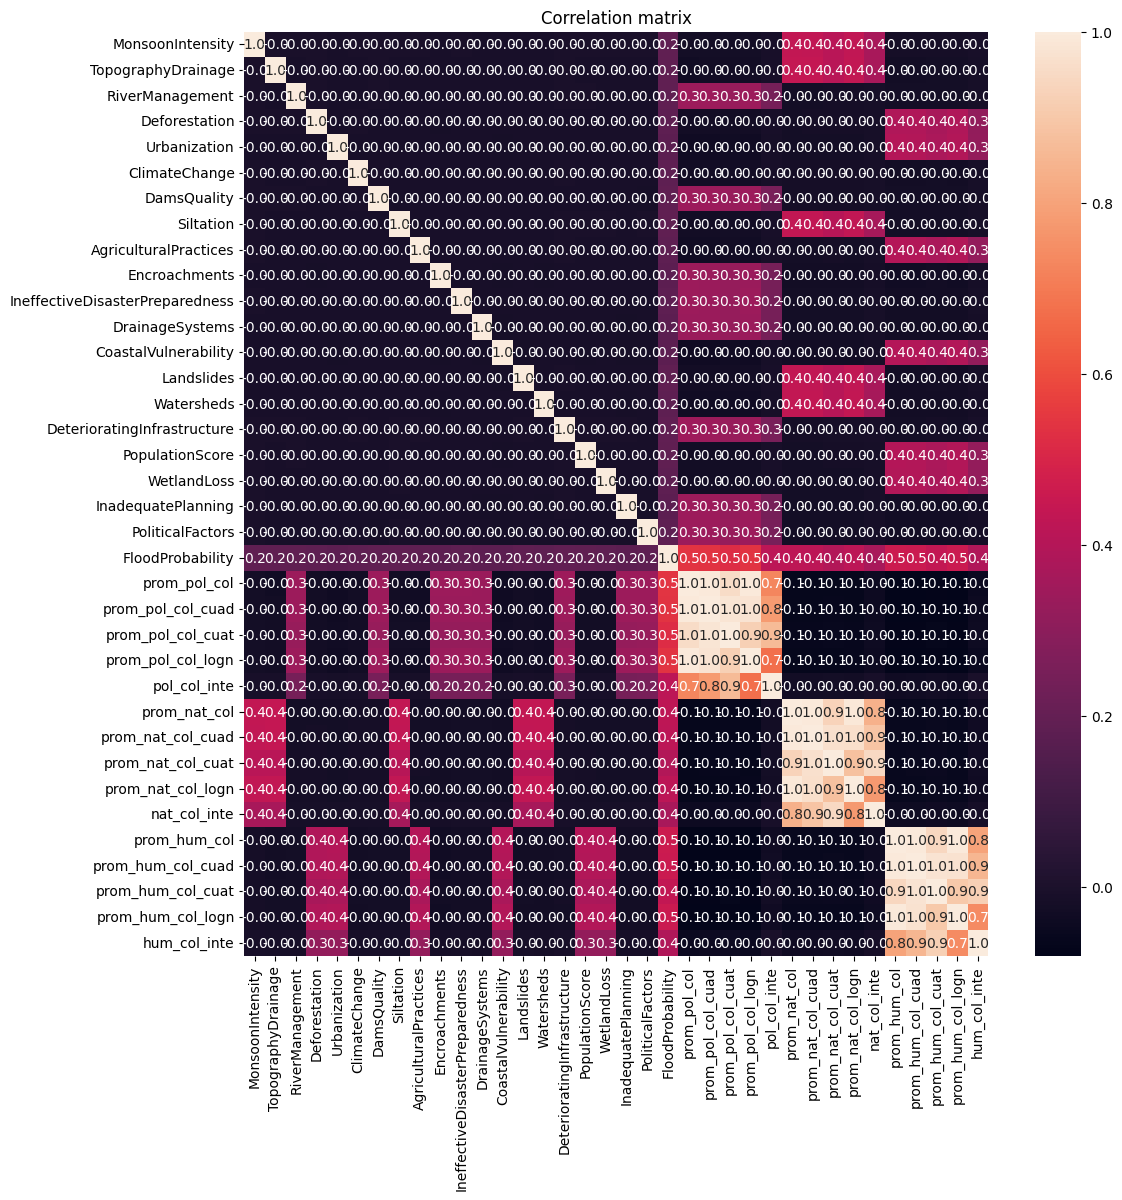

In [8]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train.corr(),annot=True, fmt='.1f')
plt.title("Correlation matrix")
plt.show()

## Pipeline creation

In [9]:
x_train_df = df_train.drop(columns=['FloodProbability'], axis=1)


x_train, x_val, y_train, y_val = train_test_split(x_train_df.values , df_train["FloodProbability"].values, test_size=0.3)

# Linear regression pipeline

In [10]:
# Numeric col transform
numeric_pipeline = Pipeline(steps=[
    ("impute",SimpleImputer(strategy="mean")),
    ("scale",StandardScaler())
])


lr_pipeline = Pipeline(steps=[("col_trans",numeric_pipeline),
                              ("model_1", LinearRegression())])

set_config(display='diagram')
display(lr_pipeline)

Pipeline(steps=[('col_trans',
                 Pipeline(steps=[('impute', SimpleImputer()),
                                 ('scale', StandardScaler())])),
                ('model_1', LinearRegression())])

In [11]:
lr_pipeline.fit(x_train,y_train)
lr_preds = lr_pipeline.predict(x_val)
print(f' Score: {lr_pipeline.score(x_val, y_val)}')
print(f' MAE: {mean_absolute_error(y_true=y_val, y_pred=lr_preds)}')
print(f' MSE: {mean_squared_error(y_true=y_val, y_pred=lr_preds)}')


 Score: 0.8464316634076772
 MAE: 0.01578225150008487
 MSE: 0.00040148600088602785


## Testing multiple models

In [12]:
from sklearn.base import BaseEstimator

class model_evaluator(BaseEstimator):
    
    def __init__(self, estimator=None):
        self.estimator = estimator

    def fit(self, x , y=None,**kwargs):
        self.estimator.fit(x,y)
        return self

    def predict(self, x, y=None):
        y_pred = self.estimator.predict(x)
        return y_pred

    def score(self, x,y):
        return self.estimator.score(x,y)
    

model =  model_evaluator()  
    
# Numeric col transform
numeric_pipeline = Pipeline(steps=[
    ("impute",SimpleImputer(strategy="mean")),
    ("scale",StandardScaler())
])
    
pipeline_steps = [
    ("col_trans",numeric_pipeline),
    ("model", model )
]

reg_pipeline = Pipeline(steps=pipeline_steps)

grid_parameters = [
    {
        "model__estimator":[LinearRegression()]
    }
    ,
    {
        "model__estimator":[Ridge()],
        "model__estimator__alpha":[0.1,1,5],
        "model__estimator__random_state":[123]

    }
    
   , {
        "model__estimator":[Lasso()],
        "model__estimator__alpha":[0.01,0.1,1] ,
        "model__estimator__random_state":[123]

    },
    {
        "model__estimator":[ElasticNet()],
        "model__estimator__alpha":[0.01,0.1,1],
        "model__estimator__random_state":[123]

   },
   {
        "model__estimator":[XGBRegressor()],
        "model__estimator__learning_rate":[0.01,0.1] ,
        "model__estimator__max_depth":[3,5,7],
        "model__estimator__min_child_weight":[1,3,5],
        "model__estimator__seed":[123],
    }
    ,
    {
        "model__estimator":[cb.CatBoostRegressor()],
        "model__estimator__learning_rate":[0.01,0.1] ,
        "model__estimator__depth":[2,4,8],
        "model__estimator__l2_leaf_reg":[0.2,1.3],
        "model__estimator__random_seed":[123]         
        
    }
]




In [13]:
# Grid search
gs = GridSearchCV(reg_pipeline, grid_parameters,scoring="neg_mean_squared_error",cv=2,verbose=1, n_jobs=-1)
model_f = gs.fit(x_train,y_train)
model_f

Fitting 2 folds for each of 40 candidates, totalling 80 fits
0:	learn: 0.0507632	total: 216ms	remaining: 3m 35s
1:	learn: 0.0505968	total: 359ms	remaining: 2m 59s
2:	learn: 0.0504327	total: 497ms	remaining: 2m 45s
3:	learn: 0.0502715	total: 639ms	remaining: 2m 39s
4:	learn: 0.0501136	total: 768ms	remaining: 2m 32s
5:	learn: 0.0499574	total: 911ms	remaining: 2m 30s
6:	learn: 0.0498022	total: 1.03s	remaining: 2m 25s
7:	learn: 0.0496506	total: 1.13s	remaining: 2m 20s
8:	learn: 0.0495009	total: 1.25s	remaining: 2m 17s
9:	learn: 0.0493540	total: 1.39s	remaining: 2m 17s
10:	learn: 0.0492085	total: 1.5s	remaining: 2m 15s
11:	learn: 0.0490676	total: 1.63s	remaining: 2m 14s
12:	learn: 0.0489236	total: 1.78s	remaining: 2m 15s
13:	learn: 0.0487799	total: 1.9s	remaining: 2m 13s
14:	learn: 0.0486423	total: 2.03s	remaining: 2m 13s
15:	learn: 0.0485023	total: 2.15s	remaining: 2m 11s
16:	learn: 0.0483639	total: 2.3s	remaining: 2m 12s
17:	learn: 0.0482270	total: 2.44s	remaining: 2m 13s
18:	learn: 0.048

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('col_trans',
                                        Pipeline(steps=[('impute',
                                                         SimpleImputer()),
                                                        ('scale',
                                                         StandardScaler())])),
                                       ('model', model_evaluator())]),
             n_jobs=-1,
             param_grid=[{'model__estimator': [LinearRegression()]},
                         {'model__estimator': [Ridge()],
                          'model__estimator__alpha': [0.1, 1, 5],
                          'model__estimator__random_state': [123]},
                         {'model__estimator':...
                          'model__estimator__min_child_weight': [1, 3, 5],
                          'model__estimator__seed': [123]},
                         {'model__estimator': [<catboost.core.CatBoostRegressor object at 0x7fa90b73d7e0>],
                          'model__estimator__depth': [2, 4, 8],
                          'model__estimator__l2_leaf_reg': [0.2, 1.3],
                          'model__estimator__learning_rate': [0.01, 0.1],
                          'model__estimator__random_seed': [123]}],
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
# Calculate MSE and MAE on the test set
y_pred_test = model_f.predict(x_val)


# Print results
print("Best Score of train set: " + str(-model_f.best_score_))  # Negative because GridSearchCV minimizes by default
print("Best parameter set: " + str(model_f.best_params_))
print("Test Score: " + str(model_f.score(x_val, y_val)))


Best Score of train set: 0.0003859788750237
Best parameter set: {'model__estimator': <catboost.core.CatBoostRegressor object at 0x7fa90b73d7e0>, 'model__estimator__depth': 8, 'model__estimator__l2_leaf_reg': 1.3, 'model__estimator__learning_rate': 0.1, 'model__estimator__random_seed': 123}
Test Score: -0.0003829440490327187


In [15]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "flooding_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_f, file)

## Submition

In [16]:
y_pred_test = model_f.predict(df_test)



submission = pd.DataFrame({
    'id': df_sample_sub.id,
    'FloodProbability': y_pred_test
})
# Save
submission.to_csv('submission.csv', index=False)